# The notebook contains
### Code for _Bulyan_ aggregation algorithm, *when gradient updates of benign clients are unknown to adversary*
### Evaluation of all of the attacks (Fang, LIE, and our SOTA AGR-tailored and AGR-agnstic) on Bulyan

## Import packages

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
from __future__ import print_function
import argparse, os, sys, csv, shutil, time, random, operator, pickle, ast, math
import numpy as np
import pandas as pd
from torch.optim import Optimizer
import torch.nn.functional as F
import torch
import pickle
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torch.multiprocessing as mp
import math
sys.path.insert(0,'./../utils/')
from logger import *
from eval import *
from misc import *

from cifar10_normal_train import *
from cifar10_util import *
from adam import Adam
from sgd import SGD

from torchmin import minimize

## Data split
Divide cifar10 data among 50 clients in Non-IID fashion using Dirichlet distribution

Graph the distribution of classes for each user

In [3]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
data_loc='/mnt/nfs/work1/amir/vshejwalkar/cifar10_data/'
# load the train dataset

train_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ])

cifar10_train = datasets.CIFAR10(root=data_loc, train=True, download=True, transform=train_transform)

cifar10_test = datasets.CIFAR10(root=data_loc, train=False, download=True, transform=train_transform)


Files already downloaded and verified
Files already downloaded and verified


In [4]:
total_tr_len = len(cifar10_train)

X={}
Y=[]
for i in range(len(cifar10_train)):
    data = cifar10_train[i][0].numpy()
    label = cifar10_train[i][1]

    if label in X:
        X[label].append(data)
    else:
        X[label] = []
        X[label].append(data)
        Y.append(label)

for label in X:
    X[label] = np.array(X[label])
Y=np.array(Y)

alpha = 20
n_users = 50

In [5]:
user_train_data_non_tensors = [[] for _ in range(n_users)]
user_train_label_non_tensors = [[] for _ in range(n_users)]

for label in Y:
    alpha_list = [alpha for _ in range(n_users)]
    probs = np.random.dirichlet(alpha_list)

    taken_index = 0

    for i, prob in enumerate(probs):
        if i == n_users - 1:
            user_train_data_non_tensors[i].extend(X[label][taken_index:])
            user_train_label_non_tensors[i].extend([label for _ in range(len(X[label]) - taken_index)])
        else:
            n_sample = math.floor(prob * len(X[label]))

            user_train_data_non_tensors[i].extend(X[label][taken_index : taken_index + n_sample])
            user_train_label_non_tensors[i].extend([label for _ in range(n_sample)])
            taken_index += n_sample

user_train_data_tensors = []
user_train_label_tensors = []

user_tr_len = []

for i in range(n_users):

    if len(user_train_data_non_tensors[i]) != len(user_train_label_non_tensors[i]):
        sys.exit(f"Shape does not match user_train_data_non_tensors[i] hsa {len(user_train_data_non_tensors[i])}, while user_train_label_non_tensors[i] has {len(user_train_label_non_tensors[i])}")


    num_data = len(user_train_data_non_tensors[i])
    user_tr_len.append(num_data)

    user_train_data_tensors.append(torch.from_numpy(np.array(user_train_data_non_tensors[i])).type(torch.FloatTensor))
    user_train_label_tensors.append(torch.from_numpy(np.array(user_train_label_non_tensors[i])).type(torch.LongTensor))

    r=np.arange(num_data)

    np.random.shuffle(r)

    user_train_data_tensors[i] = user_train_data_tensors[i][r]
    user_train_label_tensors[i] = user_train_label_tensors[i][r]

    print(f'user {i} has {user_train_data_tensors[i].shape[0]} train data, and {user_train_label_tensors[i].shape[0]} train labels')



user 0 has 1131 train data, and 1131 train labels
user 1 has 1079 train data, and 1079 train labels
user 2 has 1012 train data, and 1012 train labels
user 3 has 1011 train data, and 1011 train labels
user 4 has 914 train data, and 914 train labels
user 5 has 1026 train data, and 1026 train labels
user 6 has 918 train data, and 918 train labels
user 7 has 1080 train data, and 1080 train labels
user 8 has 1233 train data, and 1233 train labels
user 9 has 1063 train data, and 1063 train labels
user 10 has 1063 train data, and 1063 train labels
user 11 has 925 train data, and 925 train labels
user 12 has 851 train data, and 851 train labels
user 13 has 857 train data, and 857 train labels
user 14 has 1022 train data, and 1022 train labels
user 15 has 1001 train data, and 1001 train labels
user 16 has 954 train data, and 954 train labels
user 17 has 1024 train data, and 1024 train labels
user 18 has 1007 train data, and 1007 train labels
user 19 has 939 train data, and 939 train labels
user

In [6]:
X2 = []
Y2 = []

for i in range(len(cifar10_test)):
    X2.append(cifar10_test[i][0].numpy())
    Y2.append(cifar10_test[i][1])

X2=np.array(X2)
Y2=np.array(Y2)

half_index = len(X2) // 2

val_data= X2[:half_index]
val_label= Y2[:half_index]

te_data=X2[half_index:]
te_label=Y2[half_index:]

val_data_tensor=torch.from_numpy(val_data).type(torch.FloatTensor)
val_label_tensor=torch.from_numpy(val_label).type(torch.LongTensor)

te_data_tensor=torch.from_numpy(te_data).type(torch.FloatTensor)
te_label_tensor=torch.from_numpy(te_label).type(torch.LongTensor)

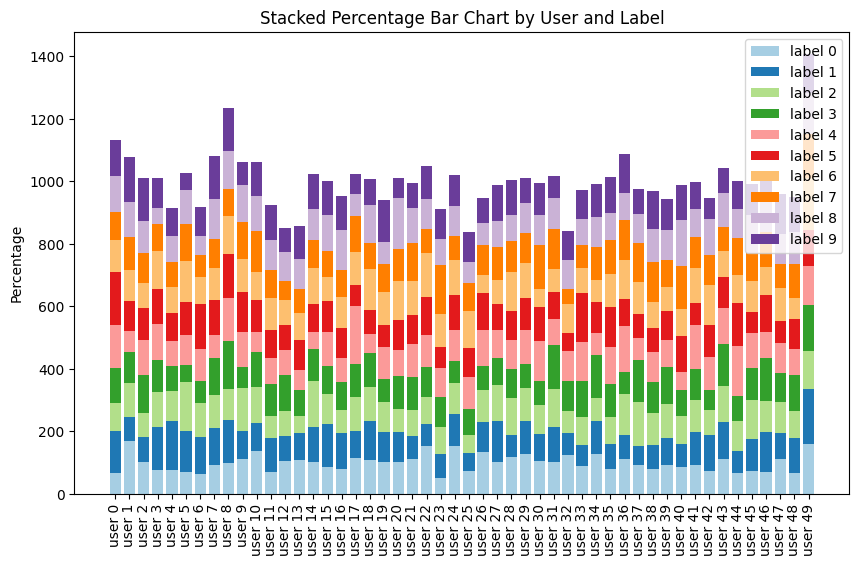

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Example data
users = [f"user {i}" for i in range(50)]
labels = [f"label {i}" for i in range(10)]


percentages = []
for user_data in user_train_label_non_tensors:
    temp_holder = []
    for label in range(10):
        temp_holder.append(user_data.count(label))
    percentages.append(temp_holder)

percentages = np.array(percentages)

# Assuming 'percentages' is populated correctly as shown previously
# Convert percentages to cumulative sum for stacking
cumulative = np.cumsum(percentages, axis=1)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Colors for each ethnicity, ensuring there are enough colors for all labels
colors = plt.cm.Paired(range(len(labels))) # Repeating colors to match the number of labels

# Create stacked bars
for i in range(len(labels)):  # Iterate over the number of labels
    if i == 0:
        ax.bar(users, percentages[:, i], color=colors[i], label=labels[i])
    else:
        ax.bar(users, percentages[:, i], bottom=cumulative[:, i-1], color=colors[i], label=labels[i])

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage')
ax.set_title('Stacked Percentage Bar Chart by User and Label')
ax.set_xticks(np.arange(len(users)))
ax.set_xticklabels(users, rotation=90)  # Rotate labels if needed
ax.legend()


plt.savefig('./non_iid_user_label_distribution.png', bbox_inches='tight')
plt.show()


## Our Aggregation Function

In [8]:
def our_mean_defense(all_updates, n_attackers, history_updates):
    # find the index of 10 users to be discarded
    discarded_history = []
    for _ in range(n_attackers):
        sum_of_distances = []
        for i, row in enumerate(history_updates):
            if i in discarded_history:
                sum_of_distances.append(-1)
                continue
            distance_sum = 0
            for j, other_row in enumerate(history_updates):
                if row != other_row and j not in discarded_history:
                    distance_sum += euclidean_distance(row, other_row)
            sum_of_distances.append(distance_sum)
        max_distance = max(sum_of_distances)
        index_of_max_distance = sum_of_distances.index(max_distance)
        discarded_history.append(index_of_max_distance)

    # get tensors in all_updates excluding the discarded ones
    mask = torch.ones(all_updates.size(0), dtype=torch.bool)  # Create a mask of ones (True)
    mask[discarded_history] = False  # Set indices in discarded_history to False
    remaining_updates = all_updates[mask]

    print('discarded index', discarded_history)

    # returns the mean of selected updates
    # after changing the attack, it should not have nan values
    return torch.nanmean(remaining_updates, dim=0)


def euclidean_distance(row1, row2):
    return math.sqrt(sum((x - y) ** 2 for x, y in zip(row1, row2)))


## Code for no defense aggregation algorithm

In [9]:
def no_defense_aggregation(user_grads):
    return torch.nanmean(user_grads, dim=0)

## our_attack_mean
$ argmin_\theta(\ -L(\theta_{attacker(s)}) + \lambda_1 |\bar{\theta_{abs\ mean\ benige\ users}} - \bar{\theta_{abs\ attacker(s)}}|$

In [10]:
def check_condition(lambda1, model_grad, loss_grad, benign_abs_mean):
    new_model_grad = model_grad + lambda1 * loss_grad
    return abs(new_model_grad.abs().mean() - benign_abs_mean) <= benign_abs_mean / 10


def find_upper_bound(lambda1, model_grad, loss_grad, benign_abs_mean):
    while check_condition(lambda1, model_grad, loss_grad, benign_abs_mean):
        lambda1 *= 2  # Exponentially increase lambda
    return lambda1


def projection(model_grad, loss_grad, benign_abs_mean):
    lambda_low = 0
    lambda_high = find_upper_bound(1, model_grad, loss_grad, benign_abs_mean)
    tolerance = 1e-6

    while lambda_high - lambda_low > tolerance:
        lambda_mid = (lambda_low + lambda_high) / 2
        if check_condition(lambda_mid, model_grad, loss_grad, benign_abs_mean):
            lambda_low = lambda_mid + tolerance
        else:
            lambda_high = lambda_mid - tolerance

    lambda1 = lambda_mid - tolerance
    return model_grad + lambda1 * loss_grad


def our_attack_mean(all_updates, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors):
    all_updates_abs_mean = all_updates.abs().mean(dim=1, keepdim=True)  # [50,1]
    benign_abs_mean_avg = all_updates_abs_mean.mean() # [1, 1]

    result_attacker_grads = []
    attacker_grads = all_updates[:n_attacker]

    for index, attacker_grad in enumerate(attacker_grads):

        attacker_tr_data_tensor = user_train_data_tensors[index].cuda()
        attacker_tr_label_tensor = user_train_label_tensors[index].cuda()

        fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)

        X = attacker_grad
        grads = []
        start_idx = 0
        for _, param in enumerate(fed_model.parameters()):
            param_=X[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            grads.append(param_)

        optimizer_fed = SGD(grads, lr=0.005)
        optimizer_fed.zero_grad()
        optimizer_fed.step(grads)

        outputs = fed_model(attacker_tr_data_tensor)
        loss = criterion(outputs, attacker_tr_label_tensor)

        optimizer_fed.zero_grad()
        loss.backward()

        param_grad=[]
        for param in fed_model.parameters():
            param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

        new_model_grad = projection(attacker_grad, param_grad, benign_abs_mean_avg)
        result_attacker_grads.append(new_model_grad)

    return torch.stack(result_attacker_grads).cuda()





## Set number of epochs

In [14]:
nepochs= 300

## Execute our attack + 10 attacker + our defense

In [12]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[10]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        updates_abs_mean = user_grads.abs().mean(dim=1, keepdim=True)

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:   # No attack
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)

        for i in range(n_users):
            history[i].extend(updates_abs_mean[i].cpu())

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./our attack + 10 attacker + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

c:\Users\Hizan\Desktop\CPEN497-FL\CPEN497-499\sgd.py:109: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1630.)
  p.data.add_(-group['lr'], d_p)


discarded index [20, 34, 45, 29, 11, 43, 44, 15, 40, 35]
epoch: 0, bulyan: at our-agr n_at 10 e 0 | val loss 2.3029 val acc 9.9229 best val_acc 9.922890


C:\Users\Hizan\AppData\Local\Temp\ipykernel_24488\3567654333.py:126: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index [16, 2, 20, 31, 34, 30, 19, 4, 45, 13]
epoch: 1, bulyan: at our-agr n_at 10 e 1 | val loss 2.3022 val acc 10.3490 best val_acc 10.349026
discarded index [16, 1, 2, 20, 31, 29, 34, 30, 19, 36]
epoch: 2, bulyan: at our-agr n_at 10 e 2 | val loss 2.3015 val acc 11.3433 best val_acc 11.343344
discarded index [16, 34, 1, 2, 29, 31, 20, 49, 30, 45]
epoch: 3, bulyan: at our-agr n_at 10 e 3 | val loss 2.3008 val acc 10.5722 best val_acc 11.343344
discarded index [16, 20, 34, 1, 2, 29, 30, 31, 49, 4]
epoch: 4, bulyan: at our-agr n_at 10 e 4 | val loss 2.3001 val acc 11.7695 best val_acc 11.769481
discarded index [16, 2, 20, 31, 30, 1, 34, 29, 19, 4]
epoch: 5, bulyan: at our-agr n_at 10 e 5 | val loss 2.2992 val acc 10.9578 best val_acc 11.769481
discarded index [16, 1, 2, 34, 20, 29, 31, 30, 40, 45]
epoch: 6, bulyan: at our-agr n_at 10 e 6 | val loss 2.2983 val acc 10.8360 best val_acc 11.769481
discarded index [16, 1, 2, 34, 20, 29, 30, 31, 41, 15]
epoch: 7, bulyan: at our-agr 

KeyboardInterrupt: 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


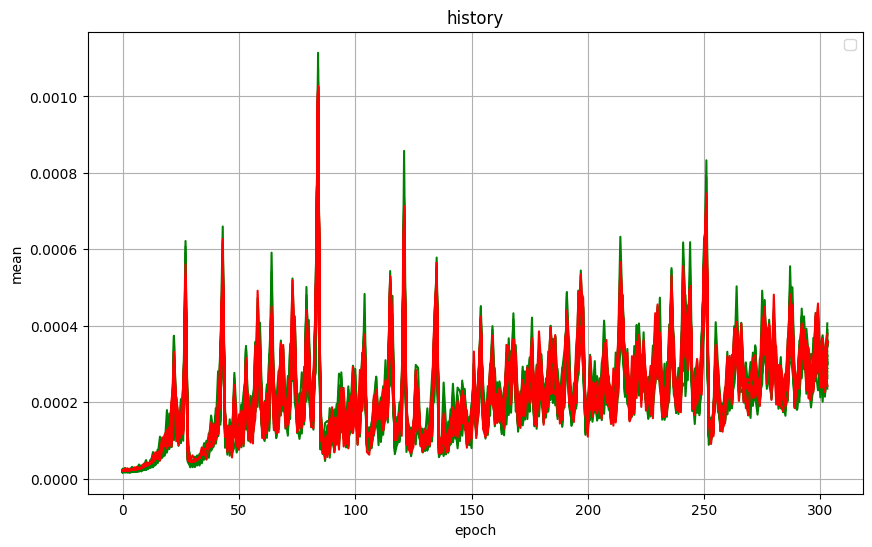

In [16]:
ne = 304

plt.figure(figsize=(10, 6))
x = np.arange(ne)
for i in range(40):
    y = history[i+10]
    plt.plot(x, y, color='green')

for i in range(10):
    y = history[i]
    plt.plot(x, y, color='red')

plt.title('history')
plt.xlabel('epoch')
plt.ylabel('mean')
plt.legend()
plt.grid(True)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


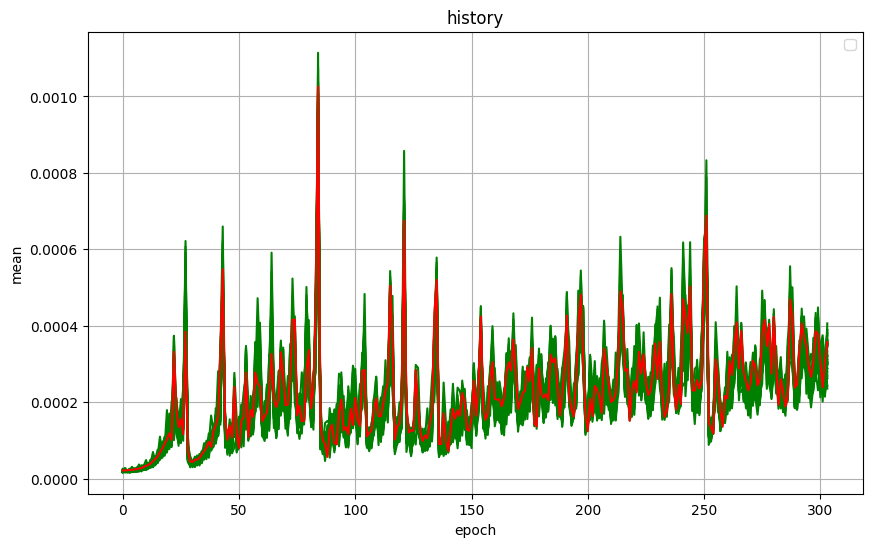

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


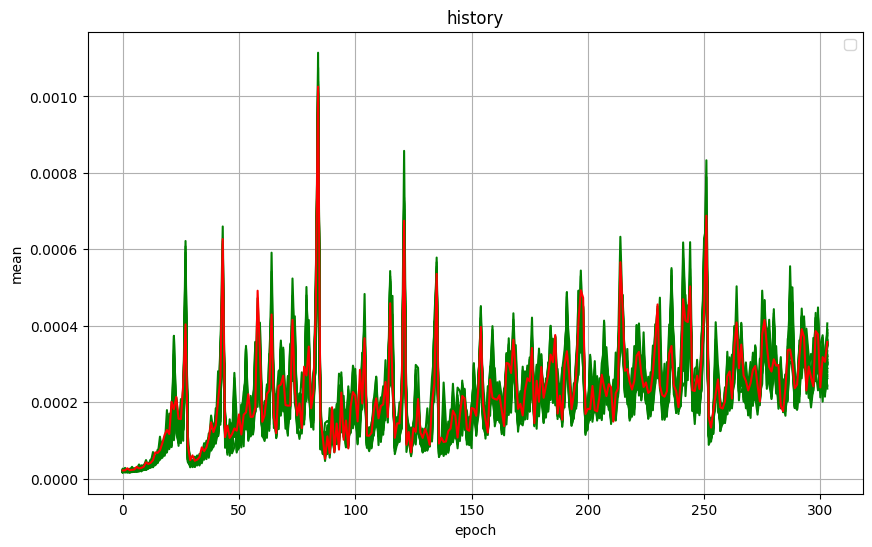

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


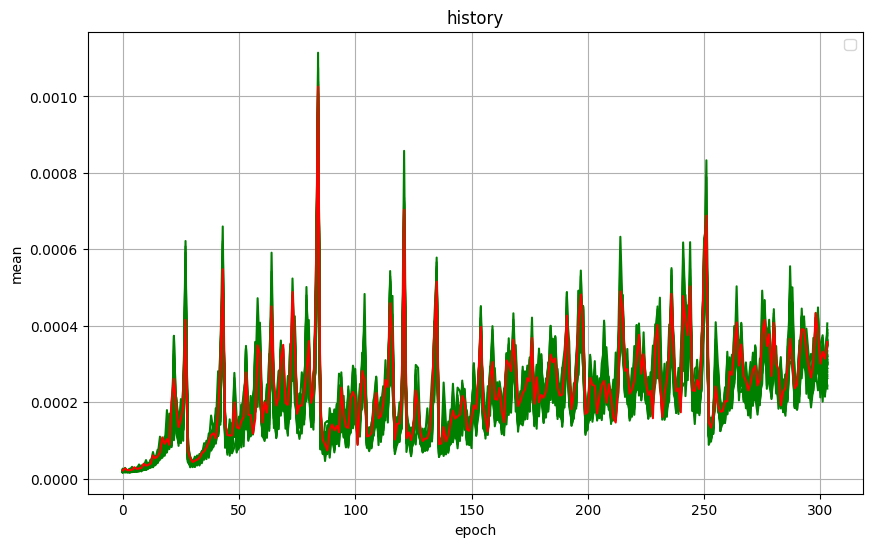

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


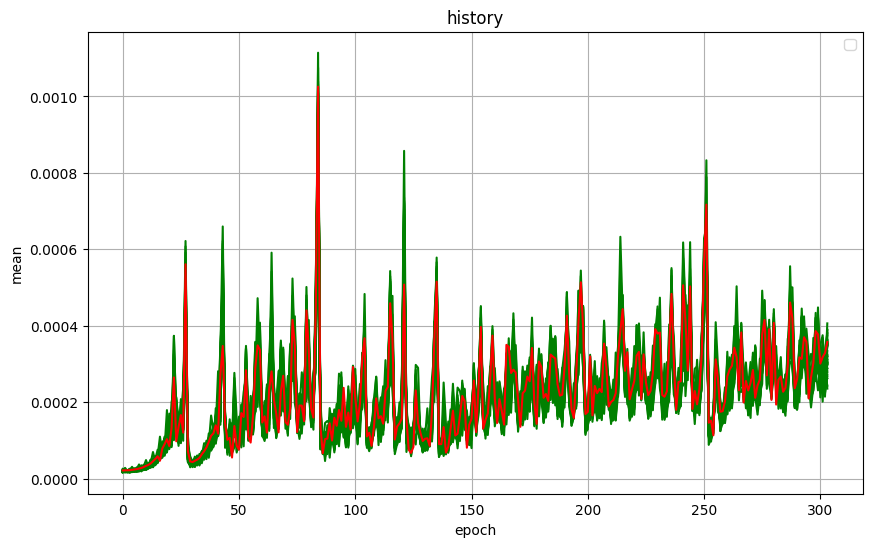

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


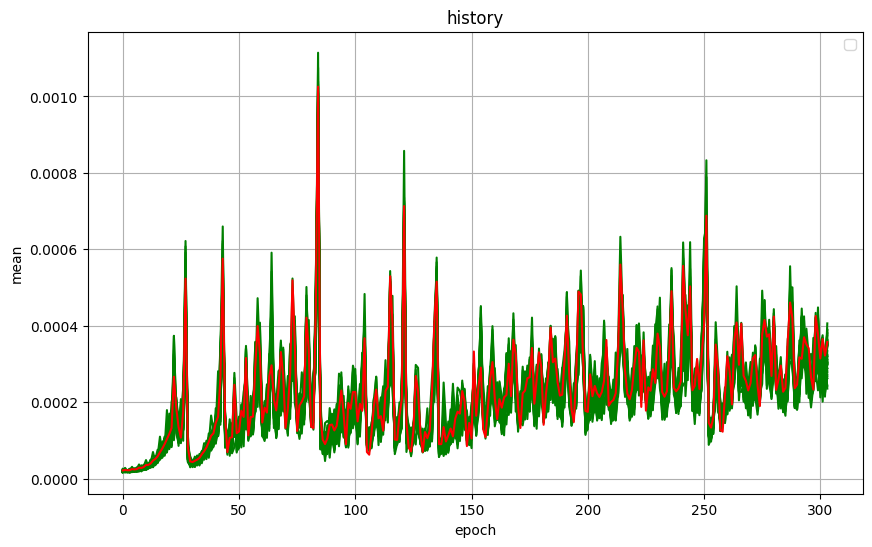

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


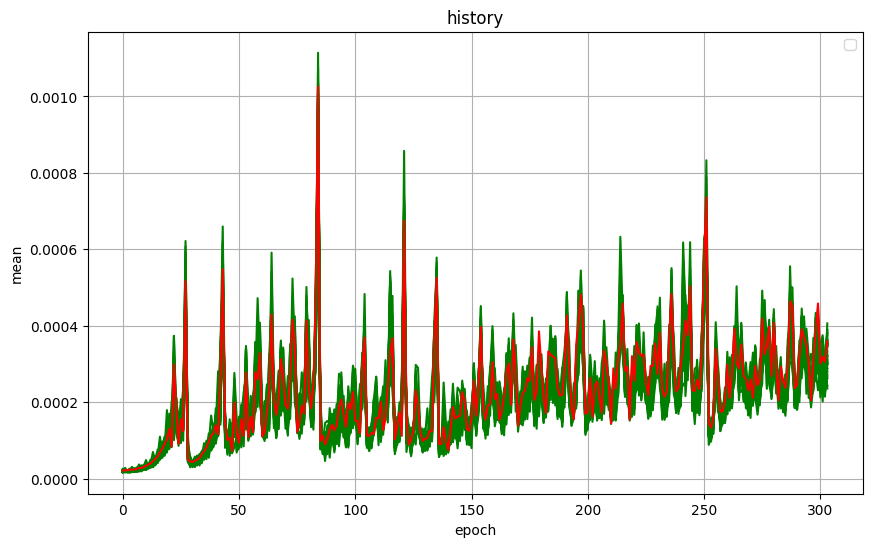

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


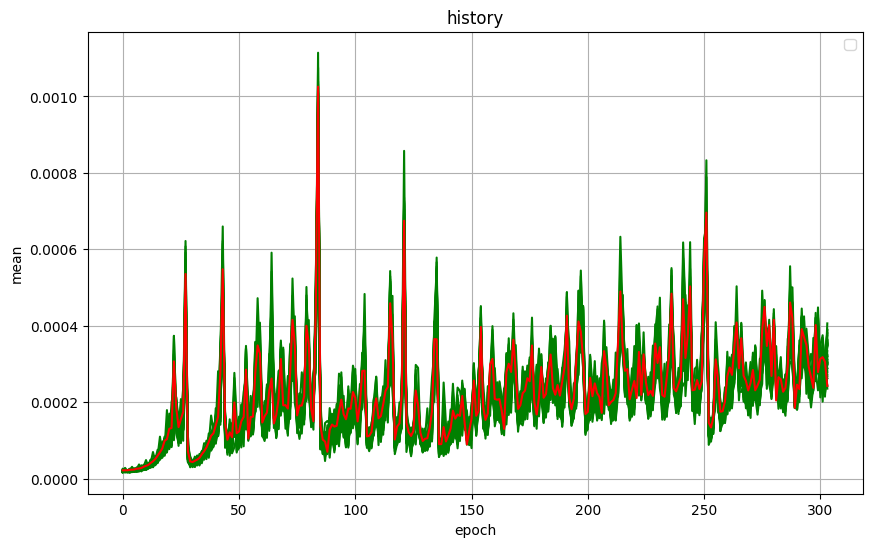

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


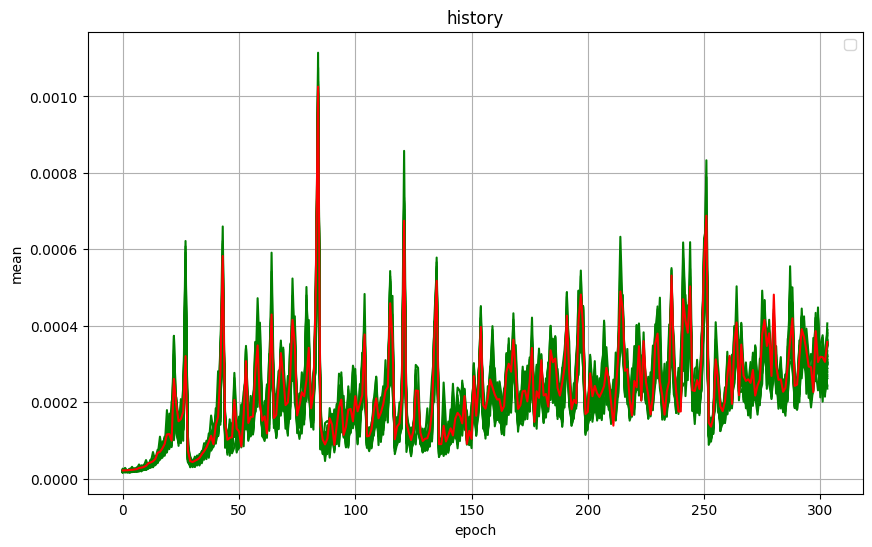

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


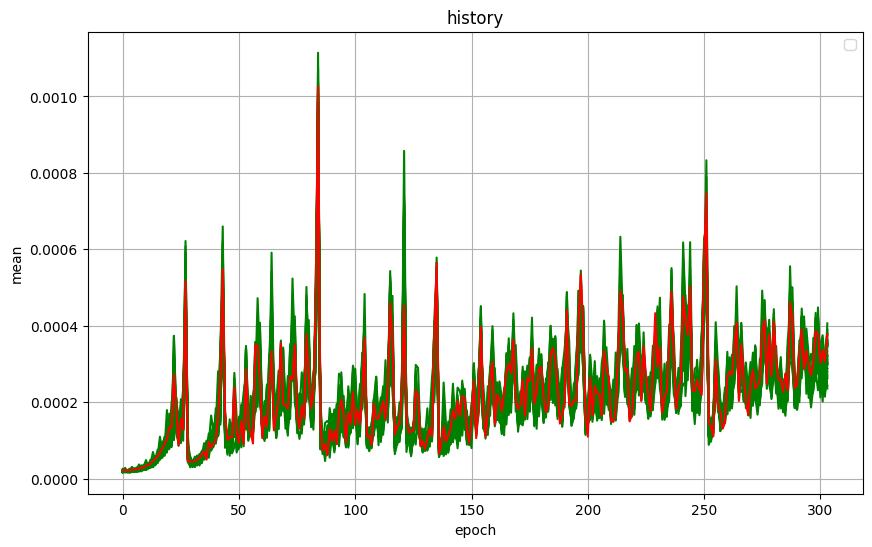

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


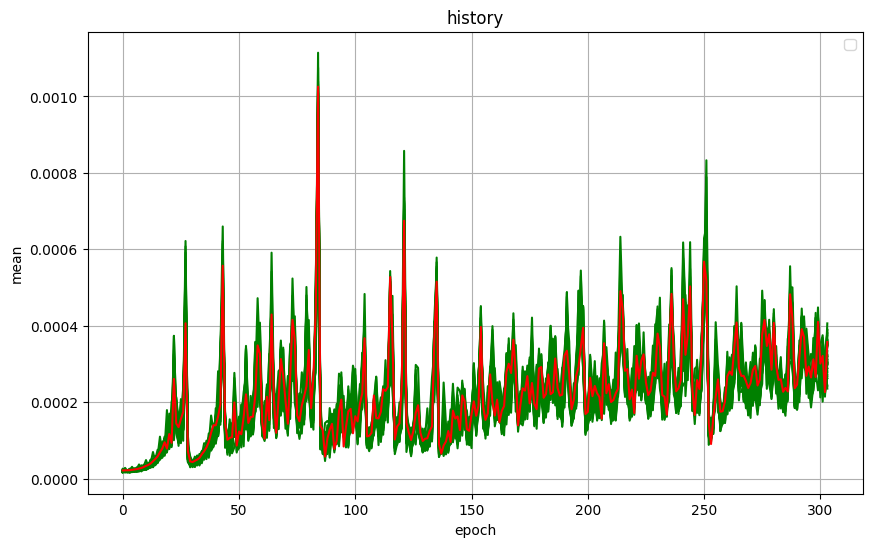

In [18]:
import matplotlib.pyplot as plt
import numpy as np

ne =  304

for j in range(10):
  plt.figure(figsize=(10, 6))
  x = np.arange(ne)
  for i in range(40):
      y = history[i+10]
      plt.plot(x, y, color='green')

  # for i in range(10):
  #     y = history[i]
  #     plt.plot(x, y, color='red')
  y = history[j]
  plt.plot(x, y, color='red')


  plt.title('history')
  plt.xlabel('epoch')
  plt.ylabel('mean')
  plt.legend()
  plt.grid(True)
  plt.savefig('./history_malicious_'+str(j)+'.png')
  plt.show()

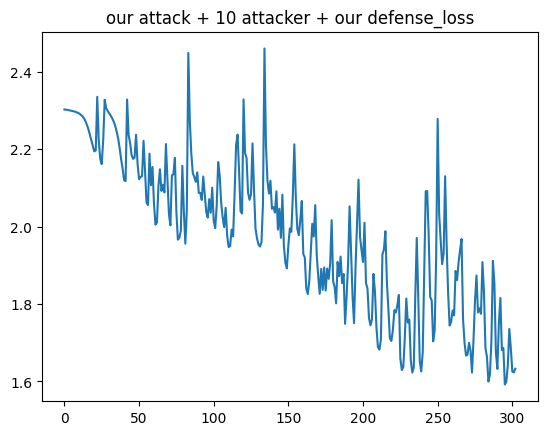

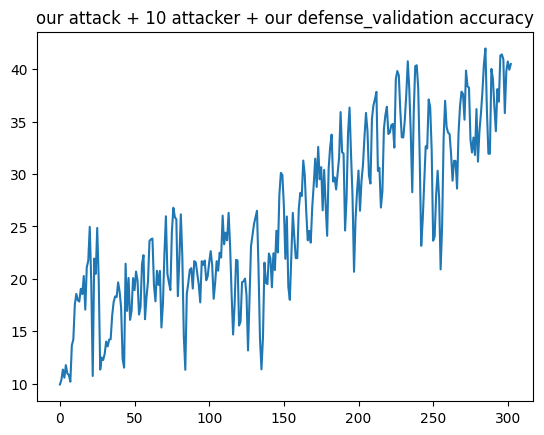

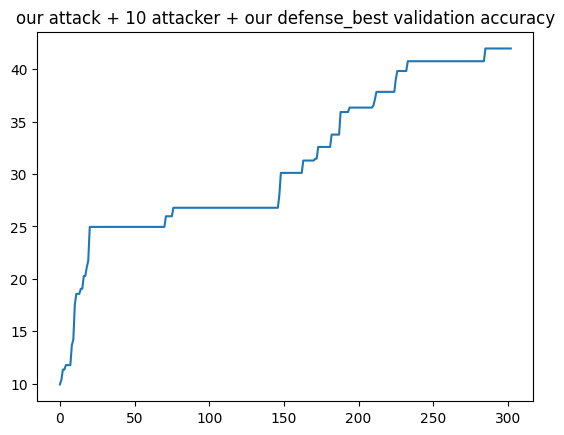

In [19]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("our attack + 10 attacker + our defense_"+col)
    plt.savefig('./our attack + 10 attacker + our defense ' + col + '.png')
    plt.show()

## Execute no attack + our defense

In [20]:
batch_size=250
resume=0

schedule=[1000]

gamma=.5
opt = 'sgd'
fed_lr=0.5
criterion=nn.CrossEntropyLoss()
use_cuda = torch.cuda.is_available()

aggregation='bulyan'
multi_k = False
candidates = []

at_type='our-agr'
dev_type ='std'
n_attackers=[0]

arch='alexnet'
chkpt='./'+aggregation

past_mean = []
past_abs_sum = []
past_median = []
past_lower_quartile = []
past_upper_quartile = []
past_std = []


for n_attacker in n_attackers:
    epoch_num = 0
    best_global_acc = 0
    best_global_te_acc = 0

    torch.cuda.empty_cache()

    fed_model, _ = return_model(arch, 0.1, 0.9, parallel=False)
    optimizer_fed = SGD(fed_model.parameters(), lr=fed_lr)

    df = pd.DataFrame(columns = ['epoch', 'loss', 'validation accuracy', 'best validation accuracy'])

    history = [[] for _ in range(n_users)]
    while epoch_num <= nepochs:
        user_grads=[]

        for i in range(n_users): # 50
            nbatches = user_tr_len[i]//batch_size

            inputs = user_train_data_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]
            targets = user_train_label_tensors[i][(epoch_num%nbatches)*batch_size:((epoch_num%nbatches) + 1) * batch_size]

            targets = targets.type(torch.LongTensor)

            inputs, targets = inputs.cuda(), targets.cuda()
            inputs, targets = torch.autograd.Variable(inputs), torch.autograd.Variable(targets)

            outputs = fed_model(inputs)
            loss = criterion(outputs, targets)
            fed_model.zero_grad ()
            loss.backward(retain_graph=True)

            param_grad=[]
            for param in fed_model.parameters():
                param_grad=param.grad.data.view(-1) if not len(param_grad) else torch.cat((param_grad,param.grad.view(-1)))

            user_grads=param_grad[None, :] if len(user_grads)==0 else torch.cat((user_grads,param_grad[None,:]), 0)

        if epoch_num in schedule:
            for param_group in optimizer_fed.param_groups:
                param_group['lr'] *= gamma
                print('New learnin rate ', param_group['lr'])

        if n_attacker > 0:
            mal_updates = our_attack_mean(user_grads, n_attacker, arch, criterion, user_train_data_tensors, user_train_label_tensors)
            malicious_grads = torch.cat((mal_updates, user_grads[n_attacker:]), 0) # torch.Size([50, 2472266])
        else:
            malicious_grads = user_grads

        if not (malicious_grads.shape[0]==50):
            print(malicious_grads.shape)

        updates_abs_mean = malicious_grads.abs().mean(dim=1, keepdim=True)
        for i in range(n_users):
            history[i].extend(updates_abs_mean[i])

        agg_grads = our_mean_defense(malicious_grads, n_attacker, history)

        del user_grads

        start_idx=0

        optimizer_fed.zero_grad()

        model_grads=[]

        for i, param in enumerate(fed_model.parameters()):
            param_=agg_grads[start_idx:start_idx+len(param.data.view(-1))].reshape(param.data.shape)
            start_idx=start_idx+len(param.data.view(-1))
            param_=param_.cuda()
            model_grads.append(param_)

        optimizer_fed.step(model_grads)

        val_loss, val_acc = test(val_data_tensor,val_label_tensor,fed_model,criterion,use_cuda)
        te_loss, te_acc = test(te_data_tensor,te_label_tensor, fed_model, criterion, use_cuda)

        is_best = best_global_acc < val_acc

        best_global_acc = max(best_global_acc, val_acc)

        if is_best:
            best_global_te_acc = te_acc


        print('epoch: %d, %s: at %s n_at %d e %d | val loss %.4f val acc %.4f best val_acc %f'%(epoch_num, aggregation, at_type, n_attacker, epoch_num, val_loss, val_acc, best_global_acc))
        new_row = pd.DataFrame([{
            'epoch': epoch_num,
            'loss': val_loss,
            'validation accuracy': val_acc,
            'best validation accuracy': best_global_acc
            }])
        df = pd.concat([df, new_row], ignore_index=True)
        df.to_csv('./no attack + our defense.csv', index=False)

        if val_loss > 1000:
            print('val loss %f too high'%val_loss)
            break

        epoch_num+=1

discarded index []
epoch: 0, bulyan: at our-agr n_at 0 e 0 | val loss 2.3027 val acc 9.8011 best val_acc 9.801136


C:\Users\Hizan\AppData\Local\Temp\ipykernel_24488\1788414890.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, new_row], ignore_index=True)


discarded index []
epoch: 1, bulyan: at our-agr n_at 0 e 1 | val loss 2.3022 val acc 10.3084 best val_acc 10.308442
discarded index []
epoch: 2, bulyan: at our-agr n_at 0 e 2 | val loss 2.3017 val acc 11.7898 best val_acc 11.789773
discarded index []
epoch: 3, bulyan: at our-agr n_at 0 e 3 | val loss 2.3012 val acc 14.4683 best val_acc 14.468344
discarded index []
epoch: 4, bulyan: at our-agr n_at 0 e 4 | val loss 2.3007 val acc 15.1177 best val_acc 15.117695
discarded index []
epoch: 5, bulyan: at our-agr n_at 0 e 5 | val loss 2.3001 val acc 15.0365 best val_acc 15.117695
discarded index []
epoch: 6, bulyan: at our-agr n_at 0 e 6 | val loss 2.2995 val acc 15.2192 best val_acc 15.219156
discarded index []
epoch: 7, bulyan: at our-agr n_at 0 e 7 | val loss 2.2988 val acc 15.4424 best val_acc 15.442370
discarded index []
epoch: 8, bulyan: at our-agr n_at 0 e 8 | val loss 2.2979 val acc 15.0365 best val_acc 15.442370
discarded index []
epoch: 9, bulyan: at our-agr n_at 0 e 9 | val loss 2.

In [ ]:
import matplotlib.pyplot as plt

# Plotting the data
for col in ['loss', 'validation accuracy', 'best validation accuracy']:
    plt.plot(df['epoch'].tolist(), df[col].tolist())
    plt.title("no attack + our defense "+col)
    plt.savefig('./no attack + cour defense ' + col + '.png')
    plt.show()